Goal: determine activity/inactiity of all genes in the genome

## Setup

In [6]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/analysis1_preliminaries/correlation_clustering.py'>

In [7]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [8]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

## Load adhesome genes and adhesome TFs

In [9]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [10]:
# Load adhesome genes
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
adhesome_chr_loci, missing_adhesome = lu.annotate_genes(df_components[['geneSymbol']], df_loc, resol)
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'].values)

In [11]:
# TF genes
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))
all_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'all_lung_adhesome_tf_genes.pkl','rb'))

## Load features for each gene

In [12]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
df_all_norm.head()

,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
RNAseq,-1.348835,0.696719,1.205265,-1.348835,0.598900,0.217067,-0.554994,-1.348835,0.545075,0.792420,...,0.634458,0.677548,0.751618,1.704392,0.668075,0.281229,0.701755,1.345637,0.664699,0.870920
CEBPB,-0.788598,-0.788598,-0.788598,0.452332,0.719486,2.078848,0.665065,-0.788598,1.298070,-0.788598,...,-0.788598,-0.788598,0.758554,-0.788598,1.158212,1.205803,0.889527,1.816979,0.740132,0.951102
CHD1,5.002786,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,2.005666,...,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480,-0.379480
CTCF,-0.780208,-0.780208,-0.780208,-0.780208,-0.780208,-0.780208,1.008129,-0.780208,-0.780208,-0.780208,...,0.911530,-0.780208,-0.780208,-0.780208,0.843302,0.698934,0.713762,1.498222,0.891377,-0.780208
DNase-seq,-1.525089,0.632814,-1.525089,0.085418,-0.360296,0.689629,0.411343,-1.525089,0.346172,0.690154,...,0.291117,0.367920,0.265765,0.581401,0.497732,0.122555,0.253598,1.295486,0.511562,0.158731


<Figure size 432x288 with 0 Axes>

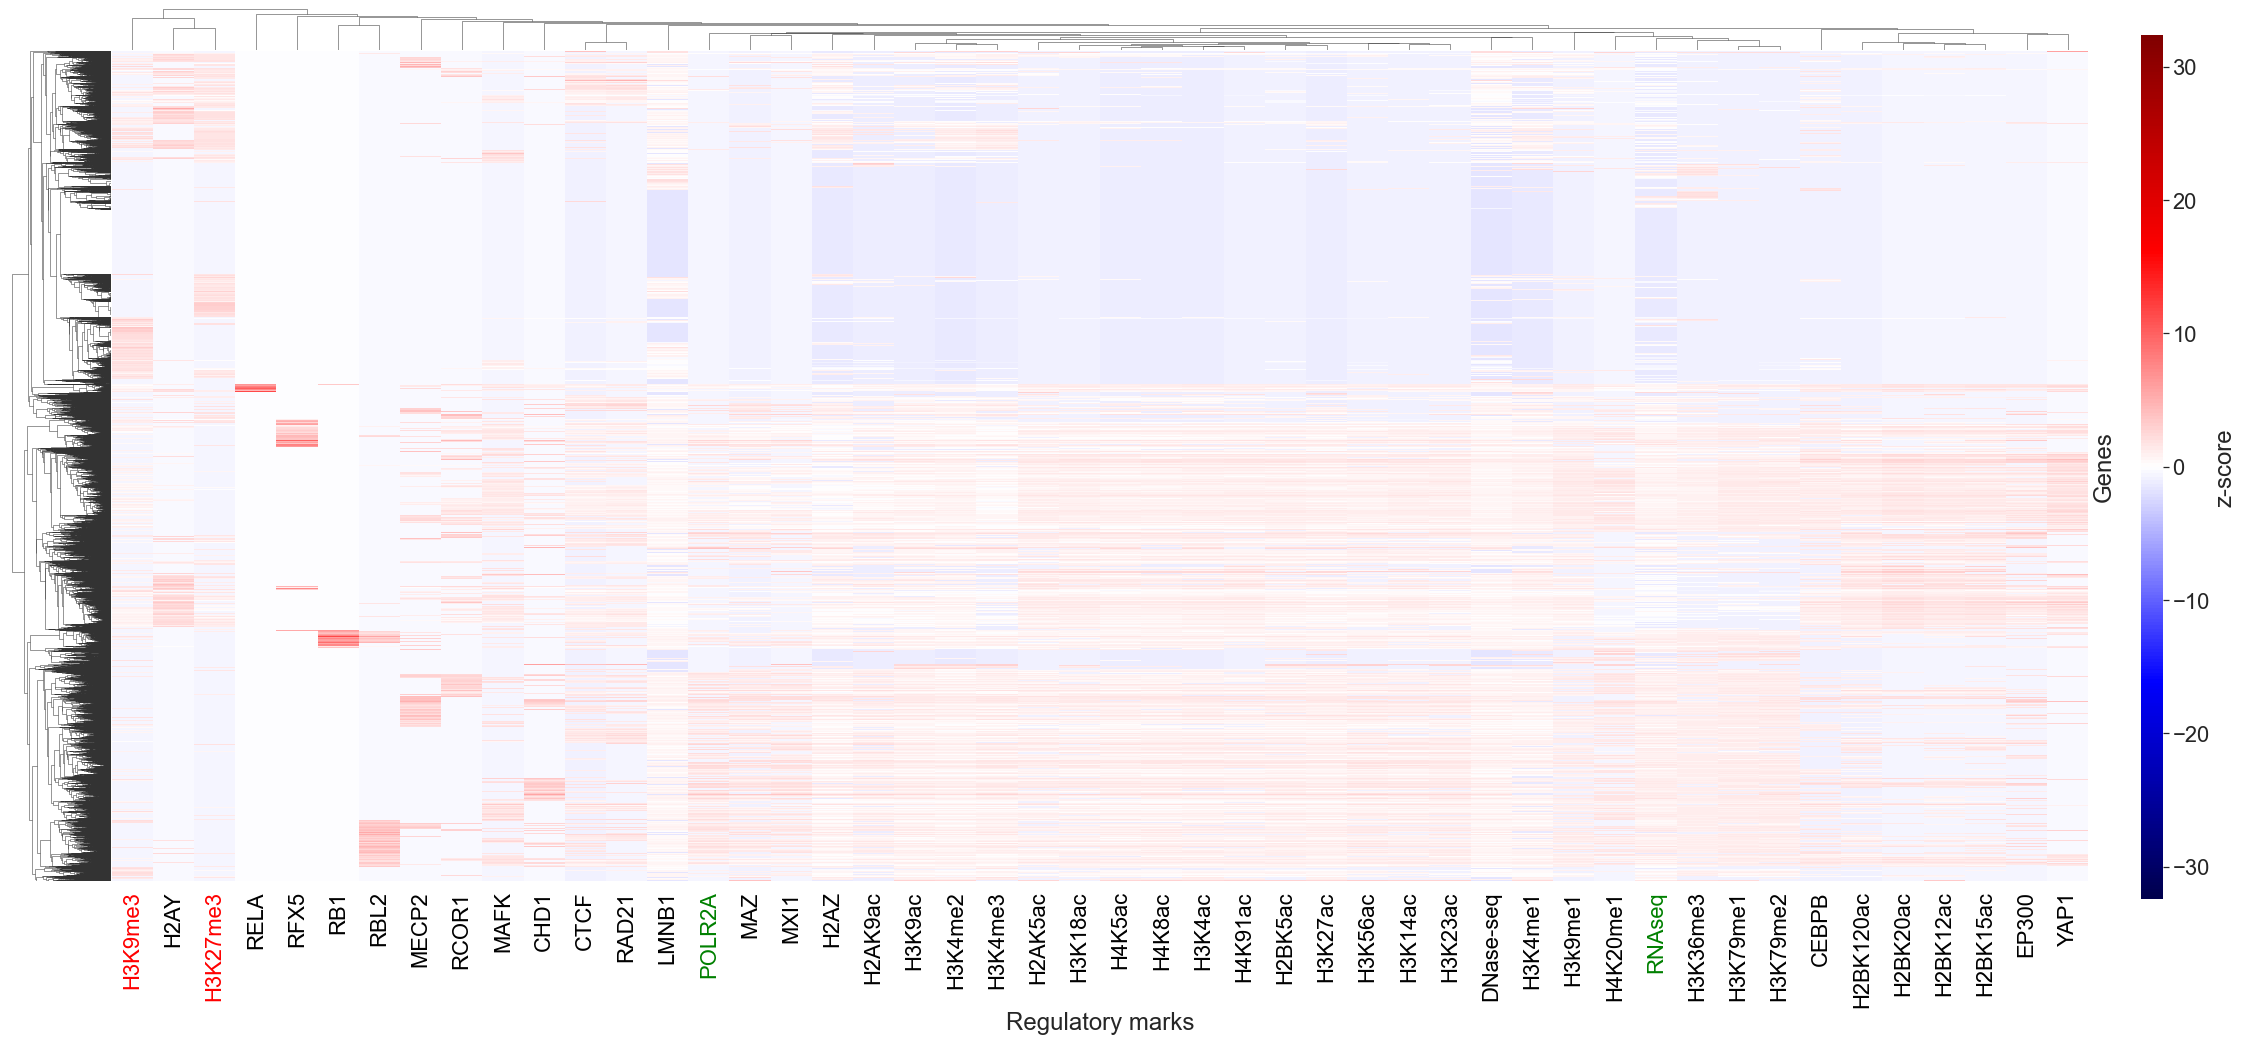

In [13]:
# Heatmap
df_all_norm.index.name = 'Regulatory marks'
df_all_norm.columns.name = 'Genes'
color_dict = {mark: 'black' for mark in df_all_norm.index}
color_dict['POLR2A'] = 'green'
color_dict['RNAseq'] = 'green'
color_dict['H3K9me3'] = 'red'
color_dict['H3K27me3'] = 'red'

sns.set(font_scale=2)
plt.figure()
g = sns.clustermap(df_all_norm.T,
               method='average',
               metric='correlation',
               row_cluster=True, col_cluster=True,
               figsize=(30,15),
               xticklabels=True, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.15, 0.01, .8),
               vmin=-np.abs(df_all_norm).max().max(), vmax=np.abs(df_all_norm).max().max(),
               dendrogram_ratio=(.05, .05), 
               cbar_kws={'label': 'z-score'})

for tick_label in g.ax_heatmap.axes.get_xticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_dict[tick_text])

# plt.savefig(saving_supp_dir+f'suppfig_3b.pdf', format='pdf')
plt.show()

## Determine active/inactive genes

In [14]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(df_all_norm.T)
print('Total number of genes = '+str(len(clustering.labels_)))
print('Number of genes in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of genes in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of genes = 25959
Number of genes in cluster 0 = 11837
Number of genes in cluster 1 = 14122


In [12]:
# PCA
pca = PCA(n_components=2)
PCs = pca.fit_transform(df_all_norm.T)
# tSNE
tsne = TSNE(n_components=2, random_state=14)
tSNEs = tsne.fit_transform(df_all_norm.T)
# UMAP
umap_embedding = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', min_dist=0.8)
umap_embeddings = umap_embedding.fit_transform(df_all_norm.T)
# Add cluster, pca and tSNE coordinates to data
df_clusters = df_all_norm.T
df_clusters['cluster'] = clustering.labels_
df_clusters['PC1'] = PCs[:,0]
df_clusters['PC2'] = PCs[:,1]
df_clusters['tSNE1'] = tSNEs[:,0]
df_clusters['tSNE2'] = tSNEs[:,1]
df_clusters['UMAP1'] = umap_embeddings[:,0]
df_clusters['UMAP2'] = umap_embeddings[:,1]
with open(saving_dir+'df_clusters_allgenes.pkl', 'wb') as f:
    pickle.dump(df_clusters, f)

/home/louiscam/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
# Load clustering
with open(saving_dir+'df_clusters_allgenes.pkl', 'rb') as f:
    df_clusters = pickle.load(f)
df_clusters['adhesome_gene'] = 0
df_clusters.loc[all_adhesome_genes,'adhesome_gene'] = 1
df_clusters['active_lung_adhesome_tf_gene'] = 0
df_clusters.loc[active_lung_adhesome_tf_genes,'active_lung_adhesome_tf_gene'] = 1
df_clusters['all_lung_adhesome_tf_gene'] = 0
df_clusters.loc[all_lung_adhesome_tf_genes,'all_lung_adhesome_tf_gene'] = 1
df_clusters['type'] = [['inactive genes','active genes'][i] for i in df_clusters['cluster']]
with open(saving_dir+'active_inactive_genes.pkl', 'wb') as f:
    pickle.dump(df_clusters, f)
df_clusters.head()

,RNAseq,CEBPB,CHD1,CTCF,DNase-seq,EP300,H2AK5ac,H2AK9ac,H2AY,H2AZ,...,PC1,PC2,tSNE1,tSNE2,UMAP1,UMAP2,adhesome_gene,active_lung_adhesome_tf_gene,all_lung_adhesome_tf_gene,type
7SK,-1.348835,-0.788598,5.002786,-0.780208,-1.525089,-0.552249,1.899807,-1.018648,-0.435575,-1.287181,...,4.433867,3.660284,-7.932166,-14.168944,11.726871,11.561399,0,0,0,active genes
A1BG,0.696719,-0.788598,-0.379480,-0.780208,0.632814,-0.552249,1.196531,1.437692,-0.435575,1.087852,...,4.054007,-3.433592,23.703711,20.141146,9.600107,6.462001,0,0,0,active genes
A1BG-AS1,1.205265,-0.788598,-0.379480,-0.780208,-1.525089,-0.552249,-0.988827,-1.018648,-0.435575,-1.287181,...,-4.365032,-1.678405,9.585607,38.839909,11.748518,4.245659,0,0,0,inactive genes
A1CF,-1.348835,0.452332,-0.379480,-0.780208,0.085418,-0.552249,-0.082444,-1.018648,-0.435575,-1.287181,...,-2.856763,2.471176,-23.714935,-9.112267,14.937500,10.379336,0,0,0,inactive genes
A2M,0.598900,0.719486,-0.379480,-0.780208,-0.360296,-0.552249,-0.988827,-1.018648,-0.435575,-0.005186,...,-1.098436,0.634440,-17.376747,-5.750140,13.066461,9.372333,0,0,0,inactive genes


In [9]:
# Summary
print('Total number of genes = '+str(len(df_clusters)))
print('Number of active genes = '+str(len(df_clusters[df_clusters['type']=='active genes'])))
print('Number of inactive genes = '+str(len(df_clusters[df_clusters['type']=='inactive genes'])))

Total number of genes = 25959
Number of active genes = 14122
Number of inactive genes = 11837


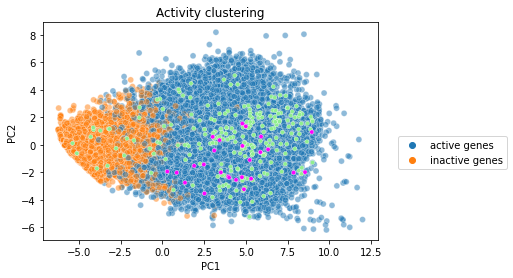

In [10]:
# Plot PC1 and PC2
%matplotlib inline
plt.figure()
sns.scatterplot(x="PC1", y="PC2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['adhesome_gene']==1], 
                size=0.1, color='lightgreen',legend=False)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['active_lung_adhesome_tf_gene']==1], 
                size=0.1, color='magenta',legend=False)
plt.legend(bbox_to_anchor=(1.4,0.5))
plt.title('Activity clustering')
plt.show()

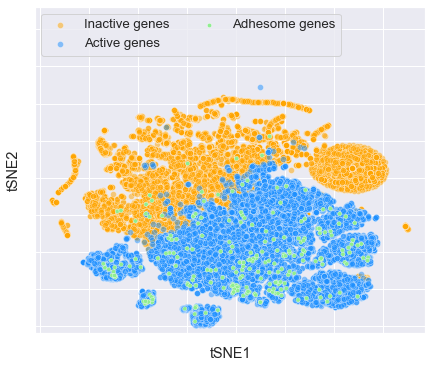

In [55]:
# Plot tSNE1 and tSNE2
%matplotlib inline
sns.set(font_scale=1.2)
plt.figure(figsize=(7,6))

g2 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='inactive genes'], alpha=0.5, 
                color='orange', legend=False)
g2.set(xticklabels=[], yticklabels=[])

g1 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='active genes'], alpha=0.5, 
                color='dodgerblue', legend=False)
g1.set(xticklabels=[], yticklabels=[])

g3 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_gene']==1], 
                size=0.1, color='lightgreen',legend=False)
g3.set(xticklabels=[], yticklabels=[])
g3.legend([
    'Inactive genes', 
    'Active genes', 
    'Adhesome genes'])
sns.move_legend(g3, 'upper left', ncol=2)

plt.ylim([-80, 140])

# plt.title('Activity clustering')
# plt.legend(bbox_to_anchor=(1.4,0.5))
# plt.savefig(saving_main_dir+f'fig_1a.pdf', format='pdf')
# plt.savefig(saving_main_dir+f'fig_4b.pdf', format='pdf')
plt.show()

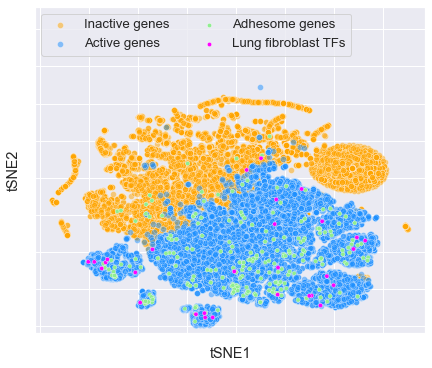

In [53]:
# Plot tSNE1 and tSNE2
%matplotlib inline
sns.set(font_scale=1.2)
plt.figure(figsize=(7,6))

g2 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='inactive genes'], alpha=0.5, 
                color='orange', legend=False)
g2.set(xticklabels=[], yticklabels=[])

g1 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='active genes'], alpha=0.5, 
                color='dodgerblue', legend=False)
g1.set(xticklabels=[], yticklabels=[])

g3 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_gene']==1], 
                size=0.1, color='lightgreen',legend=False)
g3.set(xticklabels=[], yticklabels=[])

g4 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['all_lung_adhesome_tf_gene']==1], 
                size=0.1, color='magenta',legend=False)
g4.set(xticklabels=[], yticklabels=[])
g4.legend([
    'Inactive genes', 
    'Active genes', 
    'Adhesome genes',
    'Lung fibroblast TFs'])
sns.move_legend(g4, 'upper left', ncol=2)

plt.ylim([-80, 140])

# plt.title('Activity clustering')
# plt.legend(bbox_to_anchor=(1.4,0.5))
# plt.savefig(saving_main_dir+f'fig_1a.pdf', format='pdf')
# plt.savefig(saving_main_dir+f'fig_4b.pdf', format='pdf')
plt.show()

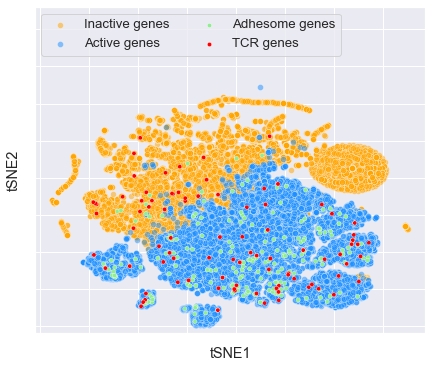

In [60]:
# Plot tSNE1 and tSNE2 for TCR genes
%matplotlib inline
with open(saving_dir+'tcr_chr_loci.pkl', 'rb') as f:
    tcr_chr_loci = pickle.load(f)
all_tcr_genes = tcr_chr_loci['gene'].unique()

sns.set(font_scale=1.2)
plt.figure(figsize=(7,6))

g2 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='inactive genes'], alpha=0.5, 
                color='orange', legend=False)
g2.set(xticklabels=[], yticklabels=[])

g1 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['type']=='active genes'], alpha=0.5, 
                color='dodgerblue', legend=False)
g1.set(xticklabels=[], yticklabels=[])

g3 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_gene']==1], 
                size=0.1, color='lightgreen',legend=False)
g3.set(xticklabels=[], yticklabels=[])

g4 = sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters.loc[all_tcr_genes,:], 
                size=0.1, color='red',legend=False)
g4.set(xticklabels=[], yticklabels=[])
g4.legend([
    'Inactive genes', 
    'Active genes', 
    'Adhesome genes',
    'TCR genes'])
sns.move_legend(g4, 'upper left', ncol=2)

plt.ylim([-80, 140])

# plt.title('Activity clustering')
# plt.legend(bbox_to_anchor=(1.4,0.5))
# plt.savefig(saving_main_dir+f'fig_1a.pdf', format='pdf')
# plt.savefig(saving_main_dir+f'fig_4b.pdf', format='pdf')
plt.show()

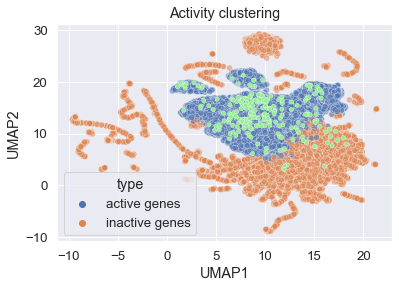

In [62]:
# Plot UMAP1 and UMAP2
%matplotlib inline
sns.set(font_scale=1.2)
plt.figure()
sns.scatterplot(x="UMAP1", y="UMAP2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="UMAP1", y="UMAP2", data=df_clusters[df_clusters['adhesome_gene']==1], 
                size=0.1, color='lightgreen',legend=False)
plt.title('Activity clustering')
plt.show()

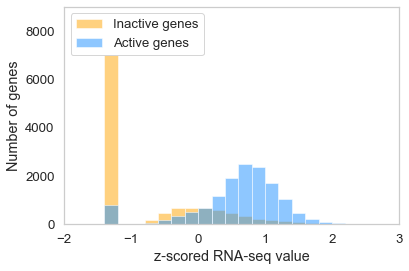

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-101.92229168169641, pvalue=0.0)


In [73]:
# Distribution of RNAseq in clusters
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=False, label='Inactive genes')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='dodgerblue', alpha=0.5, density=False, label='Active genes')
plt.xlim(-2,3)
plt.ylim(0,9000)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('Number of genes')
# plt.title('Histogram of RNAseq in the clusters')
plt.legend(loc='upper left')
# plt.savefig(saving_main_dir+f'fig_1b.pdf', format='pdf')
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'].values,
                  df_clusters.loc[df_clusters['cluster']==1]['RNAseq'].values))

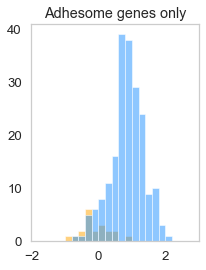

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-6.1021626878134985, pvalue=1.046427815786073e-09)


In [72]:
# Distribution of RNA-seq in clusters for adhesome loci only
%matplotlib inline
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(3,4))
plt.hist(df_clusters[(df_clusters['adhesome_gene']==1) & (df_clusters['cluster']==0)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=False, label='inactive adhesome genes')
plt.hist(df_clusters[(df_clusters['adhesome_gene']==1) & (df_clusters['cluster']==1)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='dodgerblue', alpha=0.5, density=False, label='active adhesome genes')
plt.xlim(-2,3)
# plt.xlabel('z-scored RNA-seq value')
# plt.ylabel('number of genes')
plt.title('Adhesome genes only')
# plt.legend(loc='upper left')
# plt.savefig(saving_main_dir+f'fig_1b_insert.pdf', format='pdf')
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(df_clusters[(df_clusters['adhesome_gene']==1) & (df_clusters['cluster']==0)]['RNAseq'].values,
                  df_clusters[(df_clusters['adhesome_gene']==1) & (df_clusters['cluster']==1)]['RNAseq'].values))

In [20]:
# Save active/inactive genes
active_genes = df_clusters[df_clusters['type']=='active genes'].index.values
with open(saving_dir+'active_genes.pkl', 'wb') as f:
    pickle.dump(active_genes, f)

inactive_genes = df_clusters[df_clusters['type']=='inactive genes'].index.values
with open(saving_dir+'inactive_genes.pkl', 'wb') as f:
    pickle.dump(inactive_genes, f)

In [21]:
# Save active/inactive adhesome genes
active_adhesome_genes = df_clusters[(df_clusters['type']=='active genes') & (df_clusters['adhesome_gene']==1)].index.values
with open(saving_dir+'active_adhesome_genes.pkl', 'wb') as f:
    pickle.dump(active_adhesome_genes, f)

inactive_adhesome_genes = df_clusters[(df_clusters['type']=='inactive genes') & (df_clusters['adhesome_gene']==1)].index.values
with open(saving_dir+'inactive_adhesome_genes.pkl', 'wb') as f:
    pickle.dump(inactive_adhesome_genes, f)

print('Number of active adhesome genes = '+str(len(active_adhesome_genes)))
print('Number of inactive adhesome genes = '+str(len(inactive_adhesome_genes)))

Number of active adhesome genes = 202
Number of inactive adhesome genes = 20


In [22]:
# Loci of active/inactive adhesome genes
active_adhesome_genes_loci = np.unique(adhesome_chr_loci[adhesome_chr_loci['gene'].isin(active_adhesome_genes)]['locus_id'].values)
with open(saving_dir+'active_adhesome_genes_loci.pkl', 'wb') as f:
    pickle.dump(active_adhesome_genes_loci, f)

inactive_adhesome_genes_loci = np.unique(adhesome_chr_loci[adhesome_chr_loci['gene'].isin(inactive_adhesome_genes)]['locus_id'].values)
with open(saving_dir+'inactive_adhesome_genes_loci.pkl', 'wb') as f:
    pickle.dump(inactive_adhesome_genes_loci, f)

# Comparison of gene/loci activity status

In [23]:
# Expand df_loc
df_loc2 = df_loc.copy()
df_loc2['start_locus'] = (df_loc2['chromStart']//resol)*resol
df_loc2['end_locus'] = (df_loc2['chromEnd']//resol)*resol
df_loc2['locus'] = [
    ['chr_'+df_loc2.loc[idx,'#chrom'].split('chr')[1]+'_loc_'+str(l) 
     for l in np.arange(df_loc2.loc[idx,'start_locus'], df_loc2.loc[idx,'end_locus']+resol, resol)]
    for idx in df_loc2.index
]
df_loc2 = lu.unnesting(df_loc2, ["locus"])

### All genes

In [24]:
# Active/inactive genes based on gene clustering
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)
print('Number of active genes based on gene clustering = '+str(len(active_genes)))
print('Number of inactive genes based on gene clustering = '+str(len(inactive_genes)))
print('Total number of genes considered = '+str(len(active_genes)+len(inactive_genes)))

Number of active genes based on gene clustering = 14122
Number of inactive genes based on gene clustering = 11837
Total number of genes considered = 25959


In [25]:
# Active/inactive genes based on locus clustering
with open(saving_dir+'all_active_loci_new.pkl', 'rb') as f:
    all_active_loci = pickle.load(f)
with open(saving_dir+'all_inactive_loci_new.pkl', 'rb') as f:
    all_inactive_loci = pickle.load(f)
active_genes_bis = df_loc2[df_loc2['locus'].isin(all_active_loci)]['geneSymbol'].unique()
inactive_genes_bis = df_loc2[df_loc2['locus'].isin(all_inactive_loci)]['geneSymbol'].unique()
inactive_genes_bis = np.array(list(set(inactive_genes_bis)-set(active_genes_bis)))
print('Number of active genes based on locus clustering = '+str(len(active_genes_bis)))
print('Number of inactive genes based on locus clustering = '+str(len(inactive_genes_bis)))
print('Total number of genes considered = '+str(len(active_genes_bis)+len(inactive_genes_bis)))

Number of active genes based on locus clustering = 16108
Number of inactive genes based on locus clustering = 9851
Total number of genes considered = 25959


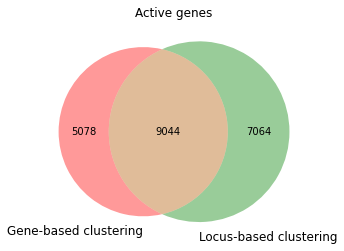

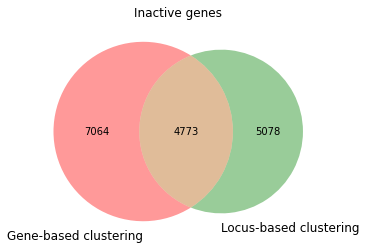

In [26]:
# Plot Venn diagrams
plt.figure()
venn2(subsets = (set(active_genes), set(active_genes_bis)), 
      set_labels = ('Gene-based clustering', 'Locus-based clustering'))
plt.title('Active genes')
plt.show()

plt.figure()
venn2(subsets = (set(inactive_genes), set(inactive_genes_bis)), 
      set_labels = ('Gene-based clustering', 'Locus-based clustering'))
plt.title('Inactive genes')
plt.show()

### Adhesome genes

In [27]:
# Active/inactive adhesome genes based on gene clustering
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)
print('Number of active adhesome genes based on gene clustering = '+str(len(active_adhesome_genes)))
print('Number of inactive adhesome genes based on gene clustering = '+str(len(inactive_adhesome_genes)))
print('Total number of adhesome genes considered = '+str(len(active_adhesome_genes)+len(inactive_adhesome_genes)))

Number of active adhesome genes based on gene clustering = 202
Number of inactive adhesome genes based on gene clustering = 20
Total number of adhesome genes considered = 222


In [28]:
# Active/inactive adhesome genes based on locus clustering
with open(saving_dir+'all_active_loci_new.pkl', 'rb') as f:
    all_active_loci = pickle.load(f)
with open(saving_dir+'all_inactive_loci_new.pkl', 'rb') as f:
    all_inactive_loci = pickle.load(f)
active_adhesome_genes_bis = df_loc2[(df_loc2['locus'].isin(all_active_loci)) &
                                    (df_loc2['geneSymbol'].isin(all_adhesome_genes))]['geneSymbol'].unique()
inactive_adhesome_genes_bis = df_loc2[(df_loc2['locus'].isin(all_inactive_loci)) &
                                      (df_loc2['geneSymbol'].isin(all_adhesome_genes))]['geneSymbol'].unique()
inactive_adhesome_genes_bis = np.array(list(set(inactive_adhesome_genes_bis)-set(active_adhesome_genes_bis)))
print('Number of active adhesome genes based on locus clustering = '+str(len(active_adhesome_genes_bis)))
print('Number of inactive adhesome genes based on locus clustering = '+str(len(inactive_adhesome_genes_bis)))
print('Total number of adhesome genes = '+str(len(active_adhesome_genes_bis)+len(inactive_adhesome_genes_bis)))

Number of active adhesome genes based on locus clustering = 138
Number of inactive adhesome genes based on locus clustering = 84
Total number of adhesome genes = 222


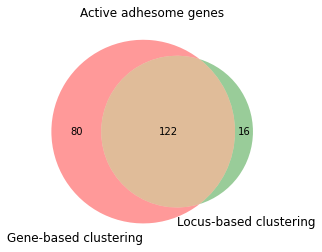

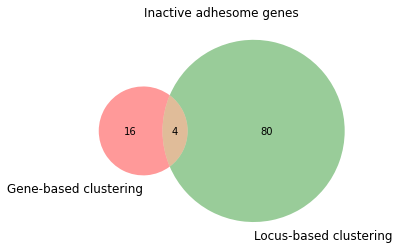

In [29]:
# Plot Venn diagrams
plt.figure()
venn2(subsets = (set(active_adhesome_genes), set(active_adhesome_genes_bis)), 
      set_labels = ('Gene-based clustering', 'Locus-based clustering'))
plt.title('Active adhesome genes')
plt.show()

plt.figure()
venn2(subsets = (set(inactive_adhesome_genes), set(inactive_adhesome_genes_bis)), 
      set_labels = ('Gene-based clustering', 'Locus-based clustering'))
plt.title('Inactive adhesome genes')
plt.show()

# Check if active genes and inactive genes are enriched in A/B compartments

In [18]:
# Load A/B compartments
with open(saving_dir+'ab_compartments.pkl', 'rb') as f:
    locus_compartment = pickle.load(f)